## HW - 3 (ALS and SGD)

## student : Trofimov Nikolay

The model loss function:

$L = \sum\limits_{u,i}(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))^{2}$+$\lambda_{xb} \sum\limits_{u} \left\Vert b_{u} \right\Vert^{2} + \lambda_{yb}\sum\limits_{i} \left\Vert b_{i} \right\Vert^{2}+
\lambda_{xf} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{yf} \sum\limits_{i} \left\Vert \textbf{y}_{i} \right\Vert^{2}$

In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)

MovieLens dataset


In [ ]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

In [2]:
cd ml-100k/

c:\Users\gospodin\Desktop\RecommenderCourse\HW3\ml-100k


C:\Users\gospodin\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Load data and create ratings matrix $r_{ij}$ 

In [3]:
# Load dataset
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our ratings matrix
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

### Split test and train

In [4]:
# Split into training and test sets. 
# Remove 10 ratings for each user and assign them to the test set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

### Metric

In [5]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

### Class implementing ALS and ExplicitMF with gradient descent and biases

This implementation has already been corrected. 

It includes the is_biased flag, which indicates whether we want a version with bias or not. 

Additionally, it implements ALS with bias.

In [6]:
from numpy.linalg import solve


class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 is_biased = False,
                 verbose=False):
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        self.is_biased = is_biased
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose


    def update_global_bias(self, ratings):
        predictions = self.user_bias[:, np.newaxis] + self.item_bias + self.user_vecs.dot(self.item_vecs.T)
        residuals = ratings - predictions
        non_zero_mask = ratings != 0
        residual_sum = np.sum(residuals[non_zero_mask])
        non_zero_count = np.sum(non_zero_mask)
        
        self.global_bias = residual_sum / non_zero_count

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 is_biased=True,
                 type='user'):

        if type == 'user':
            # y - fixed, x - latent
            if not is_biased:
                YTY = fixed_vecs.T.dot(fixed_vecs)
                lambdaI = np.eye(YTY.shape[0]) * _lambda

                for u in range(latent_vectors.shape[0]):
                    latent_vectors[u, :] = solve((YTY + lambdaI), 
                                                ratings[u, :].dot(fixed_vecs))
            else:
                ratings_theta = ratings - self.item_bias - self.global_bias
                fixed_vecs_bias = []
                for i_iter in range(self.n_items):
                    fixed_vecs_bias.append(np.insert(fixed_vecs[i_iter], 0, 1))

                fixed_vecs_bias = np.array(fixed_vecs_bias)

                Y_T_Y = fixed_vecs_bias.T.dot(fixed_vecs_bias)
                lambdaI = np.eye(Y_T_Y.shape[0]) * _lambda
                lambdaI[0, 0] = self.user_bias_reg 
                for u in range(latent_vectors.shape[0]):
                    vec = solve((Y_T_Y + lambdaI), 
                                                fixed_vecs_bias.T.dot(ratings_theta[u, :]))
                    latent_vectors[u, :] = vec[1:]
                    self.user_bias[u] = vec[0]
                
        elif type == 'item':
            # x - fixed, y - latent
            if not is_biased:
                XTX = fixed_vecs.T.dot(fixed_vecs)
                lambdaI = np.eye(XTX.shape[0]) * _lambda
                
                for i in range(latent_vectors.shape[0]):
                    latent_vectors[i, :] = solve((XTX + lambdaI), 
                                                ratings[:, i].T.dot(fixed_vecs))
            else:
                ratings_b = ratings - self.user_bias[:, np.newaxis] - self.global_bias
                fixed_vecs_bias = []
                for u_iter in range(self.n_users):
                    fixed_vecs_bias.append(np.insert(fixed_vecs[u_iter], 0, 1))

                fixed_vecs_bias = np.array(fixed_vecs_bias)
                X_T_X = fixed_vecs_bias.T.dot(fixed_vecs_bias)
                lambdaI = np.eye(X_T_X.shape[0]) * _lambda
                lambdaI[0, 0] = self.item_bias_reg 
                for i in range(latent_vectors.shape[0]):
                    vec = solve((X_T_X + lambdaI), 
                                                fixed_vecs_bias.T.dot(ratings_b[:, i]))
                    latent_vectors[i, :] = vec[1:]
                    self.item_bias[i] = vec[0]



        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))

        if self.is_biased:
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])

        self.learning_rate = learning_rate
        self.partial_train(n_iter,0)
    
    
    def partial_train(self, n_iter, iter_done):
        ctr = 1
        while ctr <= n_iter:
            if (ctr+iter_done) % 10 == 0 and self._v:
                print (f'\tcurrent iteration: {ctr+iter_done}')
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg,
                                               self.is_biased, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               self.is_biased, 
                                               type='item')
                if self.is_biased:
                    self.update_global_bias(self.ratings)
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction)
            
            if self.is_biased:
                self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
                self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])

            self.user_vecs[u, :] += self.learning_rate *\
                                    (e * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])



    def predict(self, u, i):
        if self.is_biased:
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
            
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print (f'Iteration: {n_iter}')
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff, iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print (f'MSE train:test: {round(self.train_mse[-1],2)} : {round(self.test_mse[-1],2)}\n')
            iter_diff = n_iter

#### Plots

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=3)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=3)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=25);
    plt.ylabel('MSE', fontsize=25);
    plt.legend(loc='best', fontsize=20);

##### Gradient descent with biases

In [8]:
train, test = train_test_split(ratings)
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True, is_biased=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

In [9]:
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 1.14 : 1.19

Iteration: 2
MSE train:test: 1.07 : 1.14

Iteration: 5
MSE train:test: 0.98 : 1.06

Iteration: 10
	current iteration: 10
MSE train:test: 0.92 : 1.01

Iteration: 25
	current iteration: 20
MSE train:test: 0.87 : 0.96

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 0.84 : 0.94

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 0.75 : 0.92

Iteration: 200
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
MSE train:test: 0.4 : 0.92



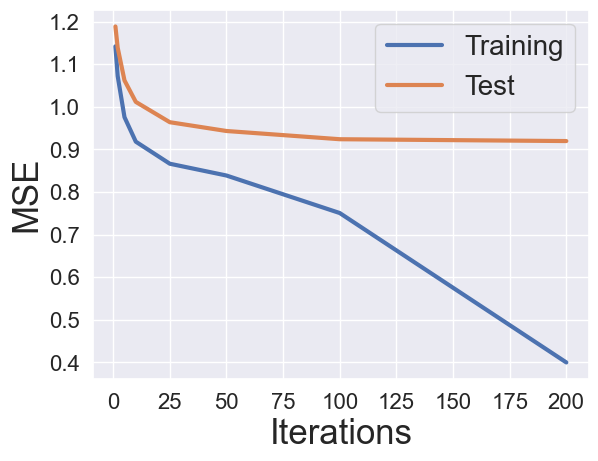

In [10]:
plot_learning_curve(iter_array, MF_SGD)

#### ALS without biases

In [11]:
MF_ALS = ExplicitMF(train, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_ALS.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 5.52 : 9.93

Iteration: 2
MSE train:test: 4.21 : 8.66

Iteration: 5
MSE train:test: 3.97 : 8.5

Iteration: 10
	current iteration: 10
MSE train:test: 3.93 : 8.48

Iteration: 25
	current iteration: 20
MSE train:test: 3.92 : 8.47

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 3.92 : 8.48

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 3.92 : 8.48

Iteration: 200
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
MSE train:test: 3.92 : 8.47



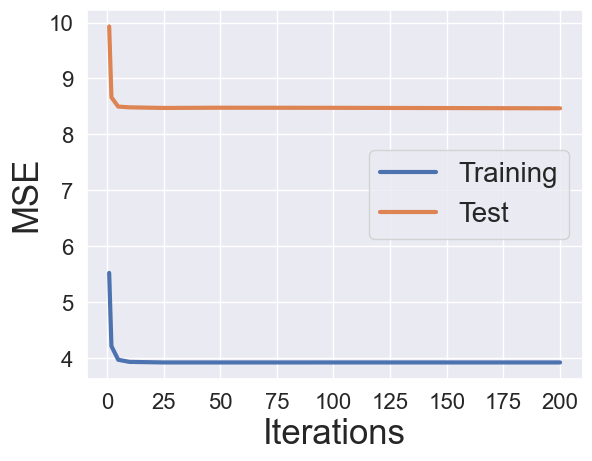

In [12]:
plot_learning_curve(iter_array, MF_ALS)

1) We will evaluate the algorithm's performance using the following criteria:

- **Mean Squared Error (MSE):**  
  This metric will be used to measure the quality of predictions.

- **Training and Prediction Time:**  
  Both training and prediction times will be recorded to assess computational efficiency.


To ensure fairness, all measurements will use the same number of iterations, controlled by the constant `const_num_iter`.

In [13]:
import time 

const_num_iter = 30

class CalcQualityTime(ExplicitMF):
    def quality_time(self, test, arr_factors, arr_learning_rate):
        arr_quality = []
        arr_predict_time = []
        arr_train_time = []
        factor_lr = [] # (factor_lr, lr)

        for n_factors in arr_factors:
            for learning_rate in arr_learning_rate:
                self.n_factors = n_factors

                start_train = time.time()
                self.train(const_num_iter, learning_rate)
                end_train = time.time()    
                
                start_predict = time.time()
                predictions = self.predict_all()
                end_predict = time.time()
                
                arr_quality.append(get_mse(predictions, test))
                arr_predict_time.append(end_predict - start_predict)
                arr_train_time.append(end_train - start_train)
                factor_lr.append((n_factors, learning_rate))

        

        return arr_quality, arr_predict_time, arr_train_time, factor_lr

Compare als (no biases) and sgd (no biases)

In [14]:
MF_ALS = CalcQualityTime(train, 40, learning='als', verbose=False, is_biased=False)
MF_SGD = CalcQualityTime(train, 40, learning='sgd', verbose=False, is_biased=False)

models_names = [(MF_ALS, 'ALS'), (MF_SGD, 'SGD')]

In [15]:
arr_n_factors = [1, 10, 25, 50]
arr_lr_ratings = [0.001, 0.01]


arr_qualities = []
arr_predict_times = []
arr_train_times = []
names = []
for model, name in models_names:
    quality_model, predict_time_model, train_time_model, factor_lr = model.quality_time(test, arr_n_factors, arr_lr_ratings)

    arr_qualities.append(quality_model)
    arr_predict_times.append(predict_time_model)
    arr_train_times.append(train_time_model)
    names.append(name)


In [16]:
pd_qualities = pd.DataFrame(arr_qualities, index=names, columns=factor_lr)
pd_qualities

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS,10.646357,10.646357,8.201532,8.201679,8.134392,8.138915,8.716404,8.721716
SGD,1.570397,0.975675,1.570425,1.023278,1.601633,1.064738,1.627296,1.032627


SGD consistently outperforms ALS** in terms of MSE, especially at higher learning rates 

ALS struggles without bias, as it relies solely on matrix factorization, which may not capture nuances like global offsets or trends in the data

In [17]:
pd_train_times = pd.DataFrame(arr_train_times, index=names, columns=factor_lr)
pd_train_times

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS,0.451218,0.421516,0.668015,0.683027,1.054377,1.073401,1.893625,1.905112
SGD,19.712504,19.717119,17.540177,17.634559,17.941160,17.522092,17.709499,17.591239


SGD takes more time to complete compared to ALS.

SGD slower because has more parametrs and more operations

In [18]:
pd_predict_times = pd.DataFrame(arr_predict_times, index=names, columns=factor_lr)
pd_predict_times

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS,1.158131,1.117106,1.143342,1.148916,1.159987,1.217046,1.188823,1.199417
SGD,1.100195,1.109077,1.127942,1.126667,1.137524,1.149790,1.141840,1.113310


Predict time is equal, because prediction calculate by the same formula 

2) To gain deeper insights into the effectiveness of bias incorporation

it is essential to compare the performance of **ALS without bias** and **ALS with bias**.


Iteration: 1
MSE train:test: 5.53 : 9.97

Iteration: 2
MSE train:test: 4.2 : 8.64

Iteration: 5
MSE train:test: 3.97 : 8.48

Iteration: 10
	current iteration: 10
MSE train:test: 3.94 : 8.46

Iteration: 25
	current iteration: 20
MSE train:test: 3.92 : 8.48

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 3.92 : 8.48

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 3.92 : 8.47



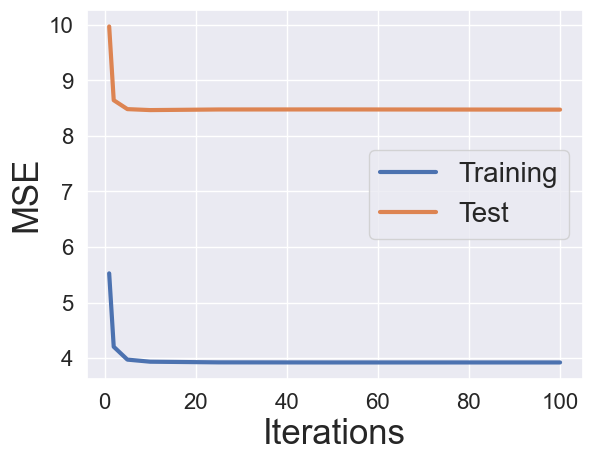

In [19]:
MF_ALS = ExplicitMF(train, 40, learning='als', verbose=True, is_biased=False)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_ALS)

Iteration: 1
MSE train:test: 1.57 : 2.29

Iteration: 2
MSE train:test: 1.61 : 2.66

Iteration: 5
MSE train:test: 1.62 : 2.79

Iteration: 10
	current iteration: 10
MSE train:test: 1.62 : 2.8

Iteration: 25
	current iteration: 20
MSE train:test: 1.62 : 2.8

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 1.62 : 2.8

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 1.62 : 2.8



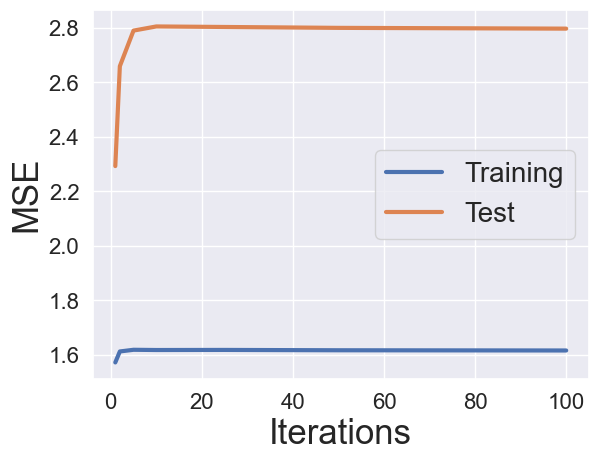

In [20]:
MF_ALS = ExplicitMF(train, 40, learning='als', user_bias_reg=0.001, item_bias_reg=0.001, user_fact_reg= 0.001, item_fact_reg=0.001,
                    verbose=True, is_biased=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_ALS)

ALS with bias significantly outperforms the version without bias in terms of both training and test MSE. 

Both models tend to stabilize after a certain number of iterations.

3) To fully understand the strengths and weaknesses of each approach, it is crucial to compare the following algorithms:


1. **ALS without Bias**
2. **ALS with Bias**
3. **SGD without Bias**
4. **SGD with Bias**

In [21]:
MF_ALS_BIASED = CalcQualityTime(train, 40, learning='als', user_bias_reg=0.001, item_bias_reg=0.001, user_fact_reg= 0.001, item_fact_reg=0.001,
                    verbose=False, is_biased=True)
MF_ALS = CalcQualityTime(train, 40, learning='als', verbose=False, is_biased=False)

MF_SGD = CalcQualityTime(train, 40, learning='sgd', verbose=False, is_biased=False)

MF_SGD_BIASED = CalcQualityTime(train, 40, learning='sgd', verbose=False, is_biased=True)

In [22]:
arr_n_factors = [1, 10, 25, 50]
arr_lr_ratings = [0.001, 0.01]

model_name = [(MF_ALS_BIASED, 'ALS_BIASED'), (MF_ALS, 'ALS'), (MF_SGD, 'SGD'), (MF_SGD_BIASED, 'SGD_BIASED')]

arr_qualities = []
arr_predict_times = []
arr_train_times = []
names = []
for model, name in model_name:
    quality_model, predict_time_model, train_time_model, factor_lr = model.quality_time(test, arr_n_factors, arr_lr_ratings)

    arr_qualities.append(quality_model)
    arr_predict_times.append(predict_time_model)
    arr_train_times.append(train_time_model)
    names.append(name)

In [23]:
pd_qualities = pd.DataFrame(arr_qualities, index=names, columns=factor_lr)
pd_qualities

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS_BIASED,1.715085,1.714952,2.039639,2.039639,2.370129,2.366986,3.120423,3.123414
ALS,10.646357,10.646357,8.201754,8.201939,8.134199,8.135894,8.710304,8.710702
SGD,1.752830,0.989450,1.559997,1.029790,1.620396,1.069315,1.637623,1.034884
SGD_BIASED,1.025806,0.998024,0.957666,1.015983,0.956582,1.019535,0.956769,1.003365


**Bias Improves Both ALS and SGD:**  
    Adding bias terms significantly improves the performance of both ALS and SGD models.

 **SGD with Bias Outperforms All Other Models:**  
  **SGD with Bias** achieves the lowest MSE across all configurations

In [24]:
pd_predict_times = pd.DataFrame(arr_predict_times, index=names, columns=factor_lr)
pd_predict_times

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS_BIASED,1.441231,1.456414,1.475122,1.452679,1.448469,1.439731,1.433341,1.428246
ALS,1.125662,1.078264,1.109906,1.107038,1.111490,1.150603,1.156477,1.152785
SGD,1.126425,1.119626,1.137614,1.137086,1.130166,1.152433,1.150765,1.145488
SGD_BIASED,1.408326,1.388795,1.412655,1.414196,1.398342,1.415900,1.413469,1.413953


Since **ALS** and **SGD** do not incorporate bias terms, they have simpler models compared to their biased counterparts.

This simplicity leads to faster prediction times.

In [25]:
pd_train_times = pd.DataFrame(arr_train_times, index=names, columns=factor_lr)
pd_train_times

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS_BIASED,1.803345,1.841236,2.013711,1.980393,2.318639,2.336743,3.236052,3.274258
ALS,0.398430,0.399575,0.627751,0.635705,0.976002,0.976999,1.831969,1.819470
SGD,19.309487,19.320187,17.272108,17.363122,17.363662,17.310051,17.433023,17.438616
SGD_BIASED,21.808362,21.756643,19.760476,19.751581,19.792469,19.502680,19.686174,19.637249


**Bias Increases Training Time:**  
  Both **ALS** and **SGD** models with bias take longer to train compared to their non-biased versions.

**SGD Requires More Training Time Than ALS:**  
  **SGD** models (biased or not) are more computationally intensive than **ALS** due to the iterative nature of the optimization process.

4. Now, it is crucial to compare the current ALS implementation with the version provided by Apache Spark's MLlib

In [26]:
from pyspark.sql import SparkSession
import setuptools.dist
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator

const_num_iter = 15

spark = SparkSession.builder \
    .appName("ALS Example with Spark CSV") \
    .getOrCreate()


schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", IntegerType(), True)
])

file_path = "u.data" 
spark_df = spark.read.csv(file_path, schema=schema, sep="\t", header=False)

spark_df = spark_df.drop("timestamp")
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

spark_df.show(2)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   196|    242|   3.0|
|   186|    302|   3.0|
+------+-------+------+
only showing top 2 rows



In [27]:
MF_ALS_BIASED = CalcQualityTime(train, 40, learning='als', user_bias_reg=0.001, item_bias_reg=0.001, user_fact_reg= 0.001, item_fact_reg=0.001,
                    verbose=False, is_biased=True)
MF_ALS = CalcQualityTime(train, 40, learning='als', verbose=False, is_biased=False)

In [28]:
arr_n_factors = [1, 10, 25, 50]
arr_lr_ratings = [0.001, 0.01]

model_name = [(MF_ALS_BIASED, 'ALS_BIASED'), (MF_ALS, 'ALS')]

arr_qualities = []
arr_predict_times = []
arr_train_times = []
for model, name in model_name:
    quality_model, predict_time_model, train_time_model, factor_lr = model.quality_time(test, arr_n_factors, arr_lr_ratings)
    
    arr_qualities.append(quality_model)
    arr_predict_times.append(predict_time_model)
    arr_train_times.append(train_time_model)
    

In [29]:
quality_als_spark = []
predict_times_als_spark = []
train_times_als_spark = []

for n_factor in arr_n_factors:
    for lr in arr_lr_ratings:
        als_spark = ALS(
            maxIter=15,
            rank = n_factor,
            regParam=lr,
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            coldStartStrategy="drop"
        )

        train_start = time.time()
        als_spark_model = als_spark.fit(train_data)
        train_end = time.time()

        predict_start = time.time()
        predictions = als_spark_model.transform(test_data)
        predict_end = time.time()
        
        evaluator = RegressionEvaluator(
            metricName="mse",
            labelCol="rating",
            predictionCol="prediction"
        )

        mse = evaluator.evaluate(predictions)
        quality_als_spark.append(mse)
        predict_times_als_spark.append(predict_end - predict_start)
        train_times_als_spark.append(train_end - train_start)

In [30]:
arr_qualities.append(quality_als_spark)
arr_predict_times.append(predict_times_als_spark)
arr_train_times.append(train_times_als_spark)

In [31]:
pd_qualities = pd.DataFrame(arr_qualities, index=['ALS_BIASED', 'ALS', 'ALS_SPARK'], columns=factor_lr)
pd_qualities

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS_BIASED,1.714969,1.714939,2.040272,2.038079,2.367800,2.371960,3.131761,3.112561
ALS,10.646357,10.646357,8.205575,8.200609,8.149528,8.140540,8.712668,8.729430
ALS_SPARK,10.693650,0.886234,1.815016,1.191441,2.510492,1.511787,2.507142,1.507194


 **ALS Spark** consistently provides much better performance than our **ALS** 

In [32]:
pd_predict_times = pd.DataFrame(arr_predict_times, index=['ALS_BIASED', 'ALS', 'ALS_SPARK'], columns=factor_lr)
pd_predict_times

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS_BIASED,1.408179,1.373522,1.396891,1.393755,1.393346,1.389166,1.386703,1.514274
ALS,1.193162,1.158872,1.148763,1.148386,1.208226,1.202687,1.179968,1.210474
ALS_SPARK,0.059191,0.021952,0.017965,0.016288,0.015146,0.013463,0.014173,0.012989


ALS Spark clearly outperforms both ALS and ALS Biased in terms of execution time. This may be related to the fact that Spark works more efficiently with memory

In [33]:
pd_train_times = pd.DataFrame(arr_train_times, index=['ALS_BIASED', 'ALS', 'ALS_SPARK'], columns=factor_lr)
pd_train_times

,"(1, 0.001)","(1, 0.01)","(10, 0.001)","(10, 0.01)","(25, 0.001)","(25, 0.01)","(50, 0.001)","(50, 0.01)"
ALS_BIASED,0.880682,0.868993,0.968684,0.984821,1.150532,1.147526,1.611005,1.696918
ALS,0.230937,0.226176,0.333055,0.344275,0.562119,0.527988,0.989878,0.971400
ALS_SPARK,3.116635,1.901286,2.081453,2.016167,2.094080,1.760573,1.998663,2.237840


ALS Biased and ALS have significantly lower training times compared to ALS Spark

## Why is ALS in this implementation not performing well? 

First, if it were rewritten in a low-level language, it could be much faster and more efficient. 

Third, it feels like a rather generic solution, and more interesting specialized methods could be developed, or the large problem could be split into smaller ones.